<a href="https://colab.research.google.com/github/tpnam0901/QTSeg/blob/dev/QTSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QTSeg: Query Tokens Hybrid Architecture for Efficient 2D Medical Image Segmentation

## Setup

### Clone repo

In [1]:
!git clone https://github.com/tpnam0901/QTSeg.git

Cloning into 'QTSeg'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 105 (delta 44), reused 102 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (105/105), 850.00 KiB | 19.77 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
%cd QTSeg/src

/content/QTSeg/src


### Download and extract dataset (2~5 mins)

In [3]:
%%bash
mkdir -p working/dataset
cd working/dataset
wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip
wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip

--2024-12-03 08:27:40--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.243.92, 52.216.40.249, 54.231.134.25, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.243.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part1_Training_Data.zip’

     0K .......... .......... .......... .......... ..........  0%  231K 44m33s
    50K .......... .......... .......... .......... ..........  0%  115K 66m48s
   100K .......... .......... .......... .......... ..........  0%  189M 44m33s
   150K .......... .......... .......... .......... ..........  0%  231K 44m32s
   200K .......... .......... .......... .......... ..........  0%  194M 35m38s
   250K .......... .......... .......... .......... ..........  0%  231K 37m6s
   30

In [4]:
%%bash
cd working/dataset
unzip ISBI2016_ISIC_Part1_Test_Data.zip
unzip ISBI2016_ISIC_Part1_Test_GroundTruth.zip
unzip ISBI2016_ISIC_Part1_Training_Data.zip
unzip ISBI2016_ISIC_Part1_Training_GroundTruth.zip

Archive:  ISBI2016_ISIC_Part1_Test_Data.zip
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000003.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000012.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000013.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000014.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000015.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000020.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000022.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000023.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000027.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000036.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000037.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000040.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000043.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000052.jpg  
 extracting: ISBI2016_ISIC_Part1_Test_Data/ISIC_0000053.jpg  
 extracting: ISBI2016_ISIC

In [5]:
%%bash
cd working/dataset
mkdir ISIC2016
mkdir ISIC2016/train
mkdir ISIC2016/test
mv ISBI2016_ISIC_Part1_Training_Data ISIC2016/train/inputs
mv ISBI2016_ISIC_Part1_Training_GroundTruth ISIC2016/train/targets
mv ISBI2016_ISIC_Part1_Test_Data ISIC2016/test/inputs
mv ISBI2016_ISIC_Part1_Test_GroundTruth ISIC2016/test/targets

Download encoder pretrained model

In [6]:
!wget -O networks/pretrained/fpn-nano.pth https://github.com/tpnam0901/QTSeg/releases/download/v0.1.0/fpn-nano.pth

--2024-12-03 08:24:57--  https://github.com/tpnam0901/QTSeg/releases/download/v0.1.0/fpn-nano.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-03 08:24:57 ERROR 404: Not Found.



## Training

### Environment

In [6]:
# prompt: command to show current OS, CUDA version, cudnn version
import platform
import subprocess

def get_cuda_version():
  """Returns the CUDA version as a string, or None if not found."""
  try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, check=True)
    output = result.stdout
    for line in output.splitlines():
      if "release" in line:
        return line.split("release")[1].strip()
  except (FileNotFoundError, subprocess.CalledProcessError):
    return None

def get_cudnn_version():
    """Returns the cuDNN version as a string, or None if not found."""
    try:
      result = subprocess.run(['cat', '/usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2'], shell=True, capture_output=True, text=True, check=True)
      output = result.stdout
      version_parts = []
      for line in output.splitlines():
        if "CUDNN_MAJOR" in line:
          version_parts.append(line.split()[2])
        elif "CUDNN_MINOR" in line:
          version_parts.append(line.split()[2])
        elif "CUDNN_PATCHLEVEL" in line:
          version_parts.append(line.split()[2])
      if len(version_parts) == 3:
        return ".".join(version_parts)
      else:
        return None
    except (FileNotFoundError, subprocess.CalledProcessError):
      return None


print(f"OS: {platform.system()}")
cuda_version = get_cuda_version()
print(f"CUDA version: {cuda_version}")
cudnn_version = get_cudnn_version()
print(f"cuDNN version: {cudnn_version}")

OS: Linux
CUDA version: 12.2, V12.2.140
cuDNN version: None


In [7]:
# prompt: command to show current python, pytorch version

import platform
import subprocess
import torch

print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")

Python version: 3.10.12
PyTorch version: 2.5.1+cu121


In [8]:
!cd .. && pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### ISIC training

Modify config for training only 35 epochs

In [9]:
%%writefile /content/QTSeg/src/configs/ISIC.py
import cv2
from configs.base import Config as BaseConfig


class Config(BaseConfig):
    # Base
    def __init__(self, **kwargs):
        super(Config, self).__init__(**kwargs)
        self.add_args()
        for key, value in kwargs.items():
            setattr(self, key, value)

    def add_args(self, **kwargs):
        self.epochs = 35
        self.transfer_epochs = 5
        self.lr_step_size: int = 5

        # ISIC2016, ISIC2017, ISIC2018
        self.data_root = "working/dataset/ISIC2016"
        self.dataloader = "ISIC2016"
        self.valid_type = "test"  # test for ISIC2016, val for ISIC2017, ISIC2018
        self.scale_value = 255.0
        self.cvtColor = cv2.COLOR_RGB2YCrCb

        self.name = self.model_type + "/" + self.encoder_model + self.decoder_model

        for key, value in kwargs.items():
            setattr(self, key, value)

Overwriting /content/QTSeg/src/configs/ISIC.py


In [10]:
!python train.py -cfg configs/ISIC.py

2024/12/03 08:36:13 INFO mlflow.tracking.fluent: Experiment with name 'QTSeg/FPNEncoderMultiQueryMaskDecoder' does not exist. Creating a new experiment.
Saving config to working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613
2024-12-03 08:36:13,532 - Saving config to working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613
2024-12-03 08:36:13,533 - name: QTSeg/FPNEncoderMultiQueryMaskDecoder
2024-12-03 08:36:13,533 - epochs: 35
2024-12-03 08:36:13,533 - val_epoch_freq: 1
2024-12-03 08:36:13,533 - transfer_epochs: 5
2024-12-03 08:36:13,533 - batch_size: 32
2024-12-03 08:36:13,533 - log_freq: 40
2024-12-03 08:36:13,533 - checkpoint_dir: working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613
2024-12-03 08:36:13,533 - ckpt_save_fred: 5000
2024-12-03 08:36:13,533 - use_amp: False
2024-12-03 08:36:13,533 - optimizer: adamw
2024-12-03 08:36:13,533 - momentum: 0.99
2024-12-03 08:36:13,534 - betas: (0.9, 0.999)
20

## Eval and Infer

In [15]:
!python eval.py -cfg working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613/cfg.json

INFO - Building dataset...
INFO - Found 379 samples in working/dataset/ISIC2016/test
INFO - Building model...
/content/QTSeg/src/networks/models.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

In [20]:
!python eval.py -cfg working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613/cfg.json --ckpt working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613/weight_best_iou.pt

INFO - Building dataset...
INFO - Found 379 samples in working/dataset/ISIC2016/test
INFO - Building model...
/content/QTSeg/src/networks/models.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

In [21]:
!python infer.py -cfg working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613/cfg.json --ckpt working/checkpoints/ISIC2016/QTSeg/FPNEncoderMultiQueryMaskDecoder/20241203-083613/weight_best_iou.pt --input_dir /content/QTSeg/src/working/dataset/ISIC2016/test/inputs --output_dir outputs

INFO - Building model...
/content/QTSeg/src/networks/models.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
INFO - Found 379 images
INFO - Running inference

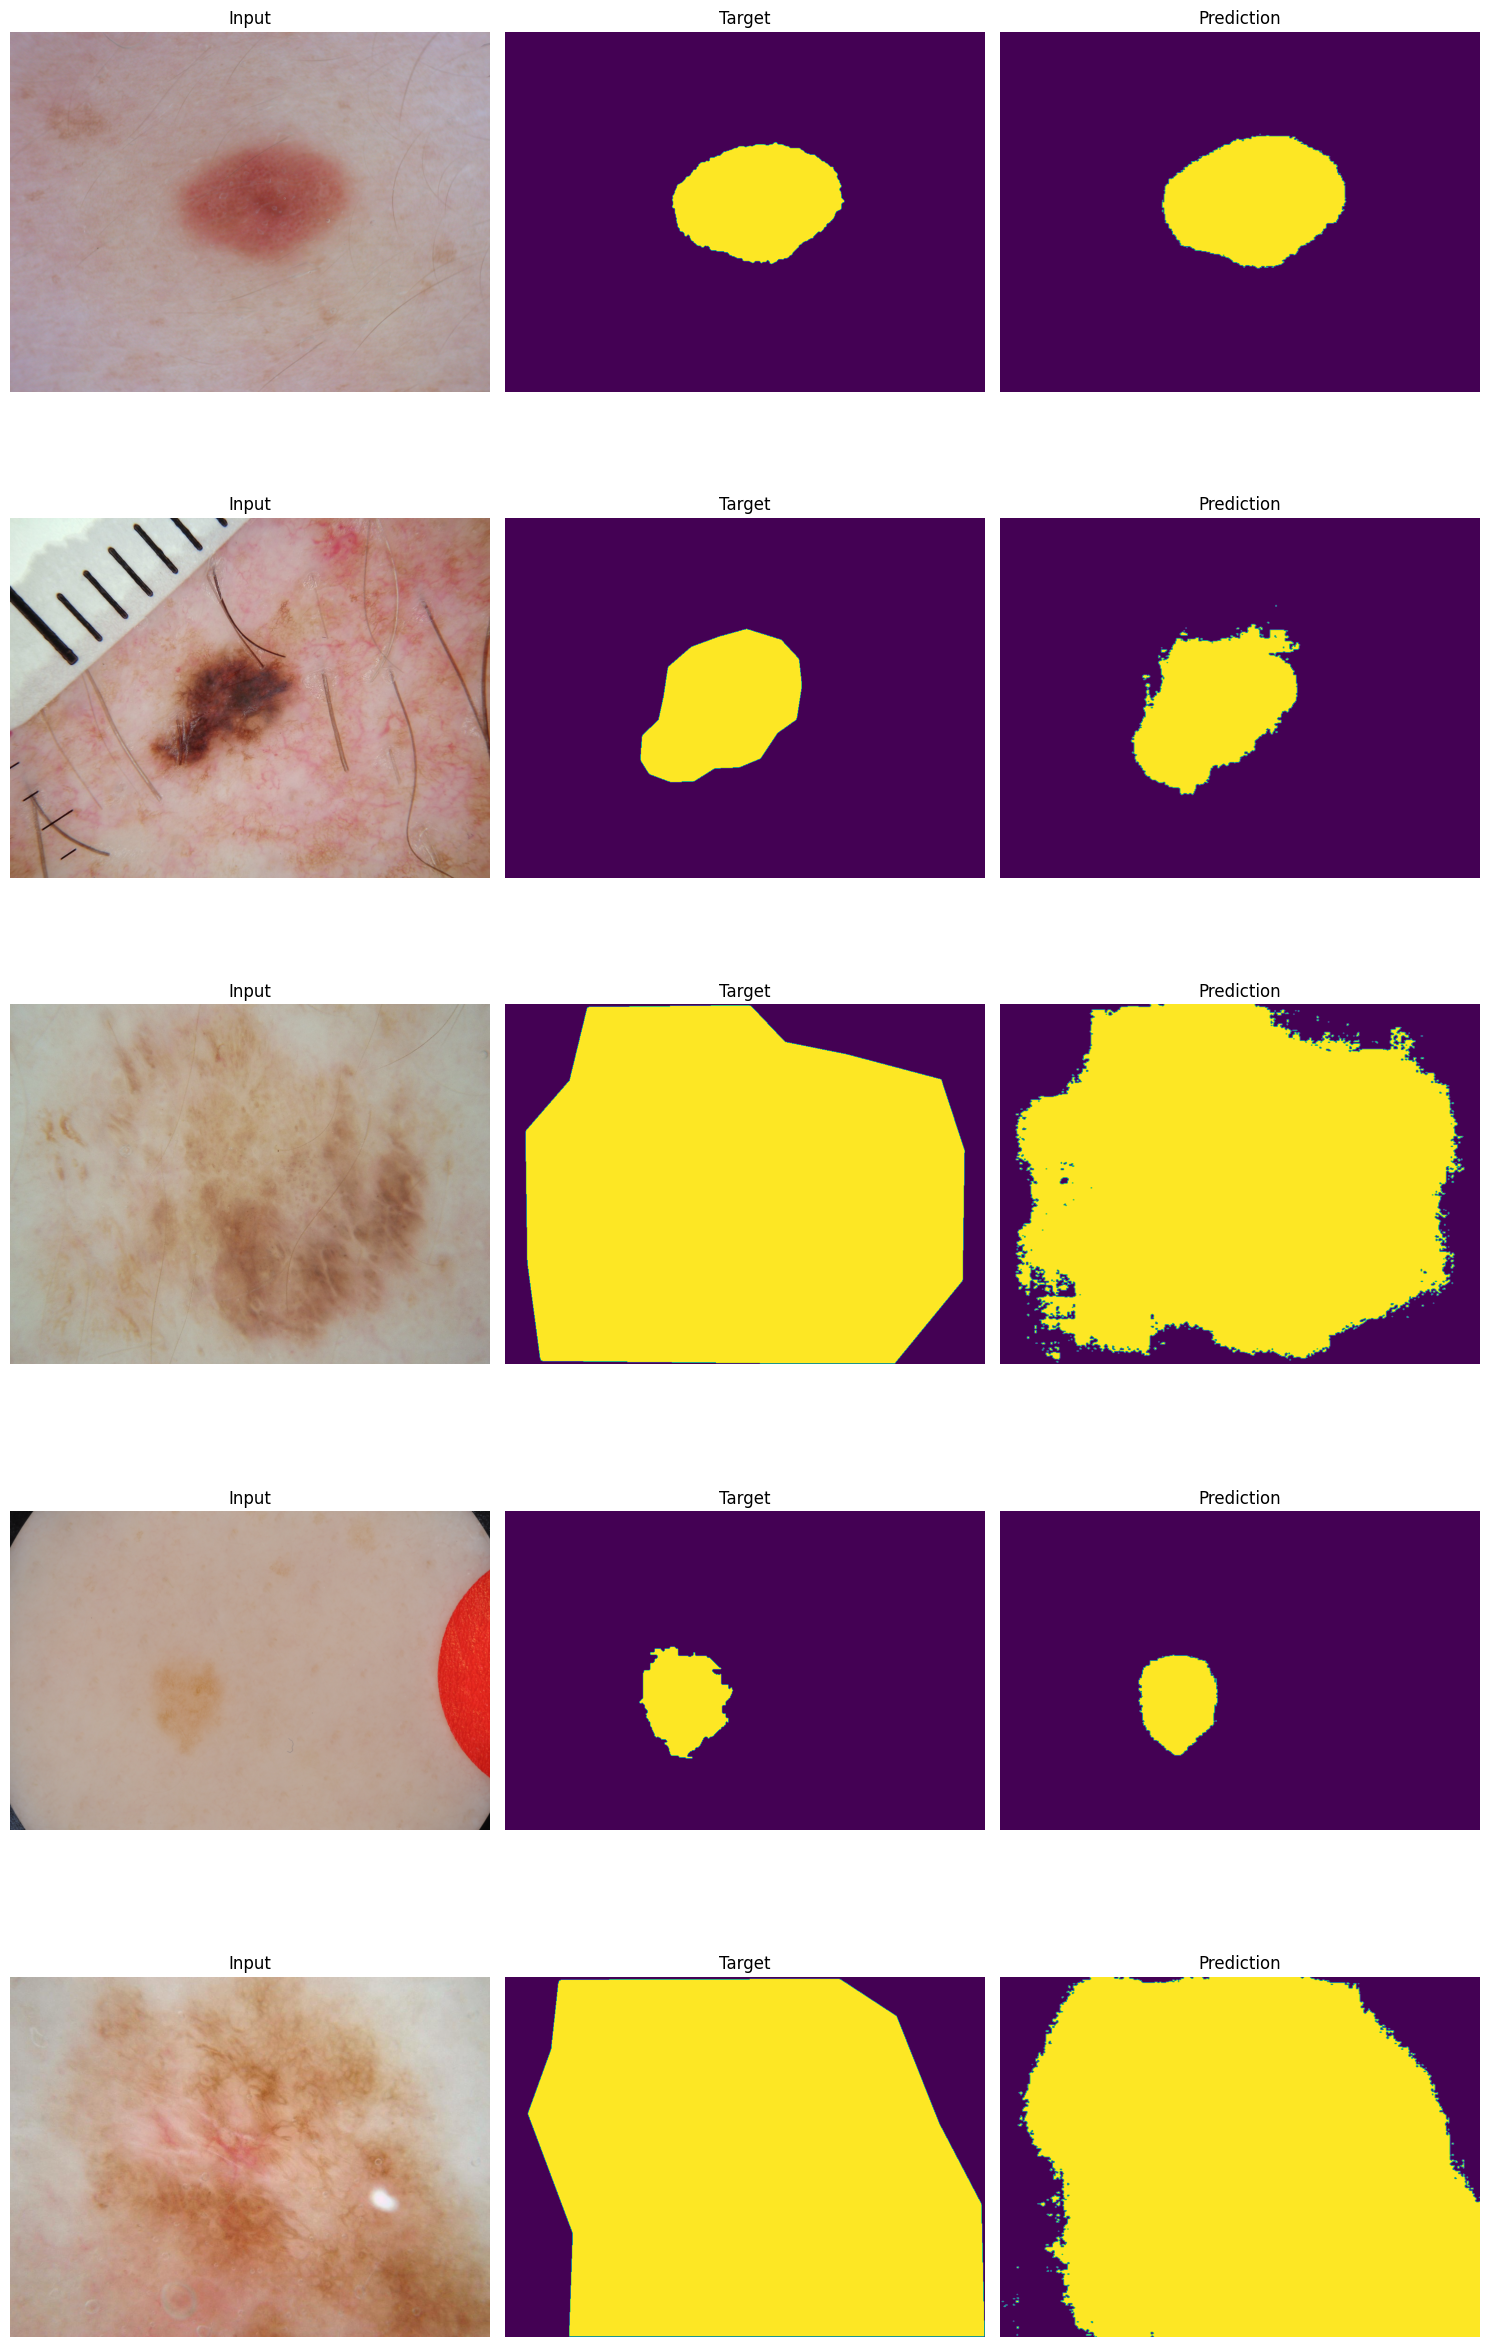

In [22]:
# prompt: Create a plot with 3 columns with matplotlib. First is the inputs images, second is the target and last one is the prediction

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

# Define paths to your image directories
input_dir = "/content/QTSeg/src/working/dataset/ISIC2016/test/inputs"
target_dir = "/content/QTSeg/src/working/dataset/ISIC2016/test/targets"
prediction_dir = "outputs"  # Replace with the actual path

# Get a list of image filenames (assuming all files are images in the directories)
filenames = os.listdir(input_dir)
image_files = [os.path.join(input_dir, filename) for filename in filenames]
target_files = [os.path.join(target_dir, filename.replace(".jpg", "_Segmentation.png")) for filename in filenames]
prediction_files = [os.path.join(prediction_dir, filename.replace(".jpg", "weight_best_iou.png")) for filename in filenames]

# Limit the number of images displayed (optional)
num_images_to_display = min(5, len(image_files))

# Create the plot
fig, axes = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))

for i in range(num_images_to_display):
  # Input image
  input_image_path = image_files[i]
  img_input = mpimg.imread(input_image_path)
  axes[i, 0].imshow(img_input)
  axes[i, 0].set_title("Input")
  axes[i, 0].axis('off')

  # Target image
  target_image_path = target_files[i]
  img_target = mpimg.imread(target_image_path)
  axes[i, 1].imshow(img_target)
  axes[i, 1].set_title("Target")
  axes[i, 1].axis('off')

  # Prediction image
  prediction_image_path = prediction_files[i]
  img_prediction = cv2.imread(prediction_image_path, cv2.IMREAD_GRAYSCALE)
  img_prediction = cv2.resize(img_prediction, (img_input.shape[1], img_input.shape[0]))
  # resize
  axes[i, 2].imshow(img_prediction)
  axes[i, 2].set_title("Prediction")
  axes[i, 2].axis('off')

plt.tight_layout()
plt.show()